In [ ]:
!pip install torchmetrics
!pip install netCDF4
!pip install basemap
!pip install eofs

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# CompVis VQ-VAE Model Loading

In [ ]:

!git clone https://github.com/CompVis/taming-transformers.git

!pip install pytorch-lightning omegaconf einops


Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 40.40 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Updating files: 100% (719/719), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 16.2 MB/s eta 0:00:00


In [ ]:
# Modify the file to remove the import of torch._six
import os

file_path = "/content/taming-transformers/taming/data/utils.py"

if os.path.exists(file_path):
    with open(file_path, "r") as f:
        content = f.read()

    # Remove the line "from torch._six import string_classes"
    content = content.replace("from torch._six import string_classes", "")

    with open(file_path, "w") as f:
        f.write(content)
    print(f"Modified {file_path} to remove torch._six import.")
else:
    print(f"File not found: {file_path}")

Modified /content/taming-transformers/taming/data/utils.py to remove torch._six import.


In [ ]:
!find /content/taming-transformers -name "*.pyc" -delete

In [ ]:
import sys
sys.path.append('/content/taming-transformers')

from taming.models.vqgan import VQModel  # it is VQ-VAE / VQGAN class

In [ ]:
import os

losses_dir = "/content/taming-transformers/taming/modules/losses/"

if os.path.exists(losses_dir):
    print(f"Contents of {losses_dir}:")
    for item in os.listdir(losses_dir):
        print(item)
else:
    print(f"Directory not found: {losses_dir}")

Contents of /content/taming-transformers/taming/modules/losses/:
vqperceptual.py
lpips.py
segmentation.py
__init__.py


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# VQ-VAE model config
ddconfig = {
    "double_z": False,
    "z_channels": 64,
    "resolution": 144,  # we use width here just to pass shape
    "in_channels": 1,
    "out_ch": 1,
    "ch": 64,
    "ch_mult": [1, 2, 4],
    "num_res_blocks": 1,
    "attn_resolutions": [],
    "dropout": 0.0,
    "num_groups": 8
}
n_embed = 1024
embed_dim = 64


lossconfig = {
    'target': 'taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator',
    'params': {
        'disc_start': 99999999,  # disables GAN
        'codebook_weight': 1.0,
        'perceptual_weight': 0.0,
    }
}



In [ ]:
vqvae_model = VQModel(ddconfig, lossconfig, n_embed, embed_dim)
vqvae_model.to(device)

""" [IMPORTANT] uncomment below two lines and load trained VQVAE Model """

# mdlpth = "VQ_VAE_new_weight_GISS_anomaly19.pt"
# vqvae_model.load_state_dict(torch.load("/content/gdrive/MyDrive/AI_MTP_2/"+mdlpth))

vqvae_model.eval()

print("model weights loaded...")

Working with z of shape (1, 64, 36, 36) = 82944 dimensions.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 175MB/s]


8.19kB [00:00, 592kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
model weights loaded...


# SST Data Loading

In [ ]:
import numpy as np
from sklearn.utils import shuffle
import torch
import xarray as xr
from scipy.signal import detrend
import netCDF4 as nc
import numpy as np



def get_datalists(path, N=25):

    train_X, train_Y = [], []
    test_X, test_Y = [], []
    val_X, val_Y = [], []

    trY_SST_ds = xr.open_dataset(path, engine="netcdf4")
    trY_SST_ds = trY_SST_ds.fillna(0)

    print(trY_SST_ds)

    for i in range(N):
        trY_SST = trY_SST_ds['sst'].values[i:i+1]

        print(f"{i+1} Data Loaded...")

        # Anomaly data
        trY_SST_detrended = detrend(trY_SST, axis=1) # Detrending trY_SST
        trY_SST = torch.tensor(trY_SST_detrended.reshape(trY_SST.shape[0],1980,48,144))  #.reshape(16800,48,144)  # Anomaly Data

        ### OR ###

        # Normal Raw data
        # trY_SST = torch.tensor(trY_SST.reshape(trY_SST.shape[0],1980,48,144))

        trY_SST_train = trY_SST[:,:1680] #1871-1989
        trY_SST_test = trY_SST[0,1680:] #1990-2010

        X_train = trY_SST_train[:,:-1,:,:].squeeze(0).unsqueeze(1)
        train_X.append(X_train)

        X_test = trY_SST_test[:-1,:,:]

        X_valid = X_test[:171].unsqueeze(1)
        val_X.append(X_valid)

        X_test = X_test[171:, :, :].unsqueeze(1)
        test_X.append(X_test)

    return train_X, test_X, val_X


In [ ]:

# path_1 = "/content/gdrive/MyDrive/AI_MTP_2/EC_Earth3_CC_historical_1850_2014.nc"
# train_X, test_X, val_X = get_datalists(path_1, N=2)

### OR ###

path_1 = "/content/gdrive/MyDrive/AI_MTP_2/GISS-E2-1-H_historical_1850_2014.nc"
train_X, test_X, val_X = get_datalists(path_1, N=2)


<xarray.Dataset> Size: 3GB
Dimensions:   (ensemble: 25, years: 165, mon: 12, lat: 48, lon: 144)
Coordinates:
  * ensemble  (ensemble) <U41 4kB 'tos_Omon_GISS-E2-1-H_historical_r10i1p1f1'...
  * years     (years) int32 660B 1850 1851 1852 1853 ... 2011 2012 2013 2014
  * mon       (mon) int32 48B 0 1 2 3 4 5 6 7 8 9 10 11
  * lat       (lat) float64 384B -88.12 -84.38 -80.62 ... 80.62 84.38 88.12
  * lon       (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    sst       (ensemble, years, mon, lat, lon) float64 3GB 0.0 0.0 ... -1.722
1 Data Loaded...
2 Data Loaded...


In [ ]:
len(train_X), len(test_X), len(val_X)

(2, 2, 2)

In [ ]:
train_X[0].shape, test_X[0].shape, val_X[0].shape    # N x C x H x W

(torch.Size([1679, 1, 48, 144]),
 torch.Size([128, 1, 48, 144]),
 torch.Size([171, 1, 48, 144]))

In [ ]:
from torch.utils.data import Dataset, DataLoader


class create_dataset_sst(Dataset):

  def __init__(self, data):
    self.data = data                 # N x C x H x W

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    sample = self.data[idx]
    return sample


In [ ]:
train_loaders = []
test_loaders = []
val_loaders = []

batch_size = 1

for i in range(len(train_X)):

  train_dataset = create_dataset_sst(train_X[i])
  train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=False))

  val_dataset = create_dataset_sst(val_X[i])
  val_loaders.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=False))

  test_dataset = create_dataset_sst(test_X[i])
  test_loaders.append(DataLoader(test_dataset, batch_size=batch_size, shuffle=False))


len(train_loaders), len(val_loaders), len(test_loaders)

(2, 2, 2)

# Sequential Data preparation

In [ ]:
from tqdm import tqdm


def get_latent_sequences(model, all_ensemble_loaders):

    latent_sequences = []

    for ensemble_loader in all_ensemble_loaders:
        ensemble_latents = []
        for sst_map in tqdm(ensemble_loader):
            sst_map = sst_map.to(device).float()
            with torch.no_grad():
                z, _, _ = model.encode(sst_map)
            z = z.squeeze(0).cpu()
            ensemble_latents.append(z)
        latent_sequences.append(torch.stack(ensemble_latents))  # (N, (T, C, H, W))

    return latent_sequences

In [ ]:

train_latent_sequences = get_latent_sequences(vqvae_model, train_loaders)
print(len(train_latent_sequences), train_latent_sequences[0].shape)

val_latent_sequences = get_latent_sequences(vqvae_model, val_loaders)
print(len(val_latent_sequences), val_latent_sequences[0].shape)

test_latent_sequences = get_latent_sequences(vqvae_model, test_loaders)
print(len(test_latent_sequences), test_latent_sequences[0].shape)


100%|██████████| 1679/1679 [00:07<00:00, 214.05it/s]


2 torch.Size([1679, 64, 12, 36])


100%|██████████| 171/171 [00:00<00:00, 241.81it/s]


2 torch.Size([171, 64, 12, 36])


100%|██████████| 128/128 [00:00<00:00, 161.33it/s]

2 torch.Size([128, 64, 12, 36])


In [ ]:
print([latent_seq.shape for latent_seq in test_latent_sequences])


[torch.Size([128, 64, 12, 36]), torch.Size([128, 64, 12, 36])]


In [ ]:

class LatentSeqDataset(torch.utils.data.Dataset):

    def __init__(self, seq, input_length=10):
        self.samples = []
        for i in range(len(seq) - input_length):
            input_seq = seq[i:i+input_length]   # (input_length, C, H, W)
            target = seq[i+input_length]        # (C, H, W)
            self.samples.append((input_seq, target))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [ ]:
seq_train_loaders = []
seq_test_loaders = []
seq_val_loaders = []

batch_size = 16
input_length = 10

for seq in train_latent_sequences:
    train_dataset = LatentSeqDataset(seq, input_length=input_length)
    seq_train_loaders.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=False))

for seq in val_latent_sequences:
    val_dataset = LatentSeqDataset(seq, input_length=input_length)
    seq_val_loaders.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=False))

for seq in test_latent_sequences:
    test_dataset = LatentSeqDataset(seq, input_length=input_length)
    seq_test_loaders.append(DataLoader(test_dataset, batch_size=batch_size, shuffle=False))


len(seq_train_loaders), len(seq_val_loaders), len(seq_test_loaders)

(2, 2, 2)

# ConvLSTM model declaration + training

In [ ]:
!git clone https://github.com/KL4805/ConvLSTM-Pytorch.git

Cloning into 'ConvLSTM-Pytorch'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 43 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 12.92 KiB | 12.92 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
import sys
sys.path.append('/content/ConvLSTM-Pytorch')

In [ ]:
from convlstm import ConvLSTM

In [ ]:
from convlstm import ConvLSTM
import torch.nn as nn
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ScaledConvLSTMWrapper(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=[128, 64], kernel_size=[(5, 5), (5, 5)], num_layers=2, init_scale=1.0):
        super().__init__()

        # Learnable scaling parameter
        self.scale = nn.Parameter(torch.tensor(init_scale, dtype=torch.float32))

        # LayerNorm
        self.layernorm = nn.LayerNorm([input_dim, 12, 36])  # (C, H, W) of latent map

        self.convlstm = ConvLSTM(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            num_layers=num_layers,
            batch_first=True,
            bias=True,
            return_all_layers=False
        )

    def forward(self, x):                           # x: (B, T, C, H, W)
        b, t, c, h, w = x.size()
        x = x.view(b * t, c, h, w)                  # Flatten time for layernorm
        x = self.layernorm(x)                       # Apply LayerNorm on (B*T, C, H, W)
        x = x.view(b, t, c, h, w)                   # Reshape back
        out, _ = self.convlstm(x)                   # Apply ConvLSTM
        output = out[0][:, -1, :, :, :]             # Get last timestep output
        return output * self.scale                  # Apply learnable scale


convlstm_model = ScaledConvLSTMWrapper(init_scale=10e4)
convlstm_model.to(device)

ScaledConvLSTMWrapper(
  (layernorm): LayerNorm((64, 12, 36), eps=1e-05, elementwise_affine=True)
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(192, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (conv_c): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (conv_cnext): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(192, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (conv_c): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (conv_cnext): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
    )
  )
)

In [ ]:

optimizer = optim.Adam(convlstm_model.parameters(), lr=3e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def criterion(true, pred):
  mse = nn.MSELoss()
  return torch.sqrt(mse(true, pred))


In [ ]:
train_losses, val_losses = [], []

print("\nTraining ConvLSTM...\n")



for epoch in range(5):

    convlstm_model.train()
    sum_loss = 0
    n = 0

    for loader in tqdm(seq_train_loaders, desc=f"Train Epoch {epoch+1}"):
        for input_seq, target in loader:
            input_seq = input_seq.to(device).float()   # (B, T, C, H, W)
            target = target.to(device).float()         # (B, C, H, W)

            # print(input_seq.shape, target.shape)

            optimizer.zero_grad()
            output = convlstm_model(input_seq)
            pred = output  # (B, C, H, W)

            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            sum_loss += loss.item() * input_seq.size(0)
            n += input_seq.size(0)

    train_loss = sum_loss / n
    train_losses.append(train_loss)


    convlstm_model.eval()
    sum_loss = 0
    n = 0

    with torch.no_grad():
        for loader in tqdm(seq_val_loaders, desc=f"Val Epoch {epoch+1}"):
            for input_seq, target in loader:
                input_seq = input_seq.to(device).float()
                target = target.to(device).float()

                output = convlstm_model(input_seq)
                pred = output  # last time step

                loss = criterion(pred, target)
                sum_loss += loss.item() * input_seq.size(0)
                n += input_seq.size(0)

    val_loss = sum_loss / n
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {train_loss}, "
          f"Val Loss: {val_loss}, "
          f"LR: {scheduler.get_last_lr()[0]}\n")

    # Save checkpoint
    if (epoch+1) % 2 == 0:
        torch.save(convlstm_model.state_dict(), "convlstm_model.pth")



Training ConvLSTM...



Val Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 1: Train Loss: 42.16954325429689, Val Loss: 8.000329364160573, LR: 0.0003



Val Epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 2: Train Loss: 5.46302309737654, Val Loss: 4.039767613322098, LR: 0.0003



Val Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 3: Train Loss: 3.2954953696072065, Val Loss: 2.6771201354376277, LR: 0.0003



Val Epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 4: Train Loss: 2.3448951482915676, Val Loss: 2.073730522801417, LR: 0.0003



Val Epoch 5: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

Epoch 5: Train Loss: 1.793223245762436, Val Loss: 1.7505290926613422, LR: 0.0003



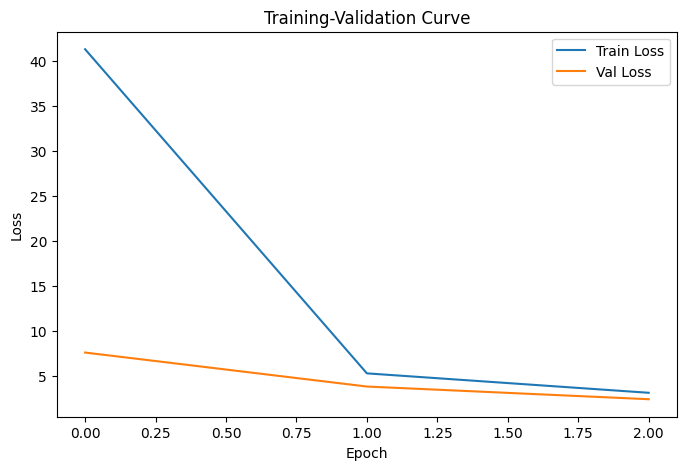

In [ ]:

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training-Validation Curve")
plt.show()
